<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#Pipeline-+-GS-для-логистичской-регрессии" data-toc-modified-id="Pipeline-+-GS-для-логистичской-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Pipeline + GS для логистичской регрессии</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект 13. «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузка и подготовка данные.
2. Обучение разных моделей. 
3. Выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import spacy
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

import time

RANDOM_STATE = 12345

Загрузим и изучим данные.

In [2]:
df_comments = pd.read_csv('toxic_comments.csv')
df_comments.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [3]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
df_comments.duplicated().sum()

0

Дубликатов и пропусков не найдено, исходные данные уже неплохого качества, но стоит удалить столбец `Unnamed`. По всей видимости, он содержит индекс, но в данном случае нам этот столбец не нужен.

In [5]:
df_comments.drop('Unnamed: 0', axis=1, inplace=True)
df_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Посомтрим на баланс классов в целевом признаке.

In [6]:
counts = df_comments['toxic'].value_counts()
counts

0    143106
1     16186
Name: toxic, dtype: int64

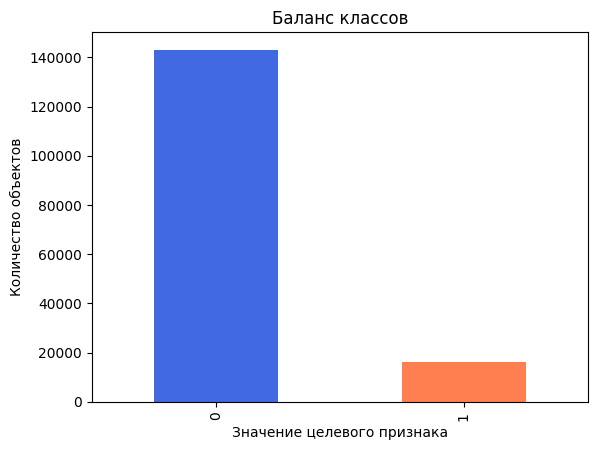

In [7]:
counts.plot(kind='bar', color=['royalblue', 'coral']);
plt.title('Баланс классов')
plt.xlabel('Значение целевого признака')
plt.ylabel('Количество объектов')
plt.show()

Можем увдиеть, что токсичных комметариев примерно в 9 раз больше, чем обычных. Некоторый дисбаланс классов присутствует, но, скорее всего, это характерно для данной области. Учтем этот факт при обучении моделей.

Прежде, чем переходить к построению моделей, подготовим корпус текстовых данных для обучения.

In [12]:
from tqdm.notebook import tqdm
tqdm.pandas()

def clear_text(text):
    pattern = r"[^a-zA-Z']"
    re_text = re.sub(pattern, ' ', text)
    re_list = re_text.split()
    res = ' '.join(re_list)
    return res.lower()

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatize(text):
    doc = nlp(sentence)
    new_string = ' '.join([token.lemma_ for token in doc])
    return new_string

Очистим тексты от всего, кроме букв и апострофов.

In [13]:
df_comments['text'] = df_comments['text'].progress_apply(clear_text)
df_comments.sample(5, random_state=RANDOM_STATE)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic
109486,expert categorizers why is there no mention of...,0
104980,noise fart talk,1
82166,an indefinite block is appropriate even for a ...,0
18721,i don't understand why we have a screenshot of...,0
128178,hello some of the people places or things you ...,0


Лемматизируем тексты.

In [14]:
df_comments['text'] = df_comments['text'].progress_apply(clear_text)
df_comments.sample(5, random_state=RANDOM_STATE)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic
109486,expert categorizers why is there no mention of...,0
104980,noise fart talk,1
82166,an indefinite block is appropriate even for a ...,0
18721,i don't understand why we have a screenshot of...,0
128178,hello some of the people places or things you ...,0


Построим облако слов для токсичных твитов, чтобы иметь представление о наиболее часто встречаемых словах.

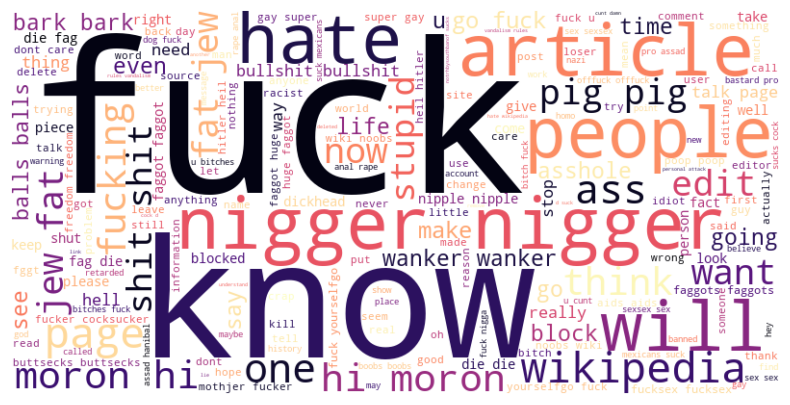

In [18]:
toxic_texts = ' '.join(review for review in df_comments.loc[df_comments['toxic'] == 1, 'text'])

wordcloud_tox = WordCloud(background_color='white', width=800, height=400, colormap='magma').generate(toxic_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tox, interpolation='bilinear')
plt.axis('off')
plt.show()

Можно увидеть, что для токсичных текстов характерны маты и оскорбительные выражения. Сравним это с облоком слов нормальных текстов.

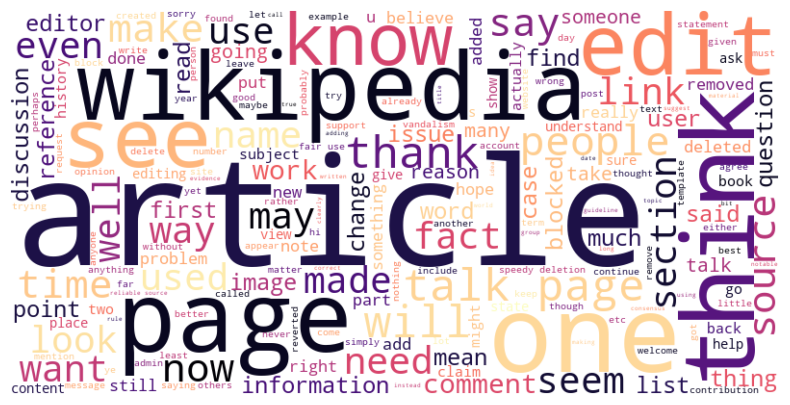

In [19]:
normal_texts = ' '.join(review for review in df_comments.loc[df_comments['toxic'] == 0, 'text'])

wordcloud_normal = WordCloud(background_color='white', width=800, height=400, colormap='magma').generate(normal_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_normal, interpolation='bilinear')
plt.axis('off')
plt.show()

Для обычных твитов не характерны нецензурные и агрессивные выражения. Мы наглядно убедились, что разница между наиболее часто употреблямыми словами в токсичных и в нормальных комментариях очень велика.

Разобьем данные на выборки: обучающую и тестовую. Валидационная выборка не понадобится, поскольку для обучения моделей мы будем применять кросс-валидацию.

In [20]:
features = df_comments['text']
target = df_comments['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, stratify = target, random_state=RANDOM_STATE)

print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (119469,)
Размер тестовой выборки: (39823,)


Векторизируем тексты  с помощью `TfidfVectorizer()`. Стоп-слова в итоговую матрицу слов добавлять не будем. Обучение векторайзера проведем на тестовой выборке.

In [23]:
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit(features_train)
features_train = tf_idf.transform(features_train)
features_test = tf_idf.transform(features_test)
print('Размер обучающей матрицы:', features_train.shape)
print('Размер тестовой матрицы:', features_test.shape)

Размер обучающей матрицы: (119469, 142639)
Размер тестовой матрицы: (39823, 142639)


**Вывод**

Данные загружены и изучены, проблем в днанных не обнаружено. Прежде, чем передавать тексты на вход алгоритмам машинного обучения, мы их подготовили следующим образом: провели очистку от лишних символов, выполнили лемматизацию, векторизовали тексты с помощью TF-IDF, поделили датафрейм на выборки.

Теперь можем переходить к обучению моделей.

## Обучение

В данном разделе мы обучим три модели: LogisticRegression, RandomForest, LightGBM. Для подбора гиперпараметро будем использовать GridSearchCV.

### LogisticRegression

Для начала обучим модель логистической регрессии. Для неё подбор гиперпараметров осуществлять не будем, сделаем обучную кросс-валидацию.

In [75]:
model_lr = LogisticRegression(solver='liblinear',
                              class_weight='balanced',  
                              random_state=RANDOM_STATE)
scores_lr = cross_val_score(model_lr, 
                            features_train, 
                            target_train, 
                            scoring = 'f1', 
                            cv=3)

avg_score_lr = np.round(scores_lr.mean(), 3)

print(f'Средняя оценка качества модели: {avg_score_lr}')

Средняя оценка качества модели: 0.743


Простая модель логистической регрессии выдаёт *F1* = 0.743. Учитывая, что модель достаточно простая, и обучение прошло очень быстро, это довольно неплохой показатель целевой метрики, хоть он и не дотягивает до удовлетворительного результата.

### RandomForest

Обучим модель RandomForest.

In [61]:
%%time


model_rf = RandomForestClassifier(class_weight='balanced', 
                                  random_state=RANDOM_STATE)
parameters = {'max_depth': [6, 8, 10],
              'n_estimators': [500, 1000, 1500]}
scores_rf = GridSearchCV(model_rf, 
                         parameters, 
                         scoring='f1', 
                         cv=3, 
                         n_jobs=-1)
scores_rf.fit(features_train, target_train)
f1_rf = np.round(scores_rf.best_score_, 3)

print('Значения гиперпараметров лучшей модели:', scores_rf.best_params_)
print('Лучшая оценка качества модели:', f1_rf)

Значения гиперпараметров лучшей модели: {'max_depth': 10, 'n_estimators': 1500}
Лучшая оценка качества модели: 0.372
CPU times: total: 9min 14s
Wall time: 25min 30s


In [62]:
rf_learning_results = pd.DataFrame(scores_rf.cv_results_).sort_values(by='rank_test_score')
rf_learning_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,371.220624,8.441625,8.585350,0.295478,10,1500,"{'max_depth': 10, 'n_estimators': 1500}",0.371349,0.367857,0.375477,0.371561,0.003114,1
7,279.137455,3.830325,6.577115,0.152977,10,1000,"{'max_depth': 10, 'n_estimators': 1000}",0.370643,0.365500,0.375941,0.370694,0.004263,2
6,149.745380,1.959794,4.137870,0.169049,10,500,"{'max_depth': 10, 'n_estimators': 500}",0.364898,0.369012,0.375725,0.369879,0.004462,3
5,351.779534,3.260800,11.082809,0.317520,8,1500,"{'max_depth': 8, 'n_estimators': 1500}",0.364271,0.363429,0.365674,0.364458,0.000926,4
3,116.786868,2.058338,4.778340,0.146882,8,500,"{'max_depth': 8, 'n_estimators': 500}",0.360420,0.364705,0.366207,0.363777,0.002452,5


С помощью GridSearchCV мы выполнили кросс-валидацию и перебрали несколько значений гиперпараметров для RandomForest. Инструмент считает, что лучшей оказалось модель с глубиной дерева 10 и количеством деревьев 1500. Однако лучший вараинт модели показывает значение метрики *F1* = 0.372. К сожалению, это очень низкий результат, гораздо хуже обычной логистической регрессии при том, что обучение случайного леса с подобром гиперпараметров заняло около 25 минут.

Анализируя таблицу результатов эксперементов, можно сказать, что значение метрики *F1* возрастает с ростом гиперпараметров, но рост крайне медленный. По всей видимости, деревья не очень подходят для решения задач с таким большим количеством признаков.

### LightGBM

Обучим модель LightGBM.

In [24]:
%%time


model_lgbm = LGBMClassifier(learning_rate=0.15, 
                            class_weight='balanced', 
                            boosting_type='gbdt', 
                            objective='binary', 
                            random_state=RANDOM_STATE)
parameters = {'max_depth': [6, 8, 10],
              'n_estimators': [500, 1000, 1500]}
scores_lgbm = GridSearchCV(model_lgbm, 
                           parameters, 
                           scoring='f1',
                           cv=3,
                           n_jobs=-1)
scores_lgbm.fit(features_train, target_train)
f1_lgbm = np.round(scores_lgbm.best_score_, 3)

print('Значения гиперпараметров лучшей модели:', scores_lgbm.best_params_)
print('Лучшая оценка качества модели:', f1_lgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 12140, number of negative: 107329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.133337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 609631
[LightGBM] [Info] Number of data points in the train set: 119469, number of used features: 11854
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [25]:
lgbm_learning_results = pd.DataFrame(scores_lgbm.cv_results_).sort_values(by='rank_test_score')
lgbm_learning_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,416.169853,47.654322,2.776734,0.378087,10,1500,"{'max_depth': 10, 'n_estimators': 1500}",0.766953,0.765213,0.759520,0.763895,0.003174,1
7,412.956973,22.048063,2.108543,0.148532,10,1000,"{'max_depth': 10, 'n_estimators': 1000}",0.768027,0.765635,0.757269,0.763644,0.004612,2
5,595.756774,22.741777,2.986409,0.385686,8,1500,"{'max_depth': 8, 'n_estimators': 1500}",0.763645,0.766904,0.759630,0.763393,0.002975,3
4,452.122396,11.243858,1.853084,0.078256,8,1000,"{'max_depth': 8, 'n_estimators': 1000}",0.764429,0.766040,0.757457,0.762642,0.003725,4
2,519.418061,62.565328,2.500739,0.013338,6,1500,"{'max_depth': 6, 'n_estimators': 1500}",0.760425,0.762704,0.757864,0.760331,0.001977,5


Лучшая LightGBM модель обучалась со следующими значениями гиперпараметров: максимальная глубина — 10, кол-во деревьев — 1500. Модель выдаёт в среднем значение метрики *F1* = 0.764. По таблице видно, что с ростом кол-ва деревьев растет и целевая метрика, но крайне медленно. На перебор гиперпараметров и обучение всех моделей ушло более 25 мин., а обучение моделей с большим количеством деревьев заняло бы еще больше времени.

В целом, можно сказать, что модель LightGBM преодалела планку в *F1* = 0.75, которая диктуется условием задачи. Именно эту модель будет проверять на тестовой выборке для получения итогового результата метрики.

**Вывод**

В данном разделе мы провели обучение с кросс-валидацией для LogisticRegression, и подбор гиперпараметров для двух моделей: RandomForest,  LightGBM. Наилушим показателем метрики *F1* обладает модель **LightGBM**, чуть хуже себя показала **LogisticRegression**, и самый неудачный результат показала модель **RandomForest**. И это при том, что  модели LogisticRegression и RandomForest обучались равное количество времени. 

Проверим нашу лучшую модель **LightGBM** на тестовой выборке.

## Тестирование модели

Протестируем выбранную модель машинного обучения с найденными гиперпараметрами.

In [16]:
model=  LGBMClassifier(n_estimators=1000,
                       max_depth=10,
                       learning_rate=0.15,
                       class_weight='balanced', 
                       boosting_type='gbdt', 
                       objective='binary', 
                       random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 12142, number of negative: 107327
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.892309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573210
[LightGBM] [Info] Number of data points in the train set: 119469, number of used features: 10692
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [32]:
model = scores_lgbm.best_estimator_
predictions = model.predict(features_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [33]:
f1 = f1_score(target_test, predictions)
print('Итоговое значение метрики F1:', f1)

Итоговое значение метрики F1: 0.7766918223431895


Результирующее значение *F1* = 0.777. Это даже выше, чем на валидационной выборке. Мы успешно справились с задачей, преодолев указанный порог.

### Pipeline + GS для логистичской регрессии 

In [31]:
%%time

train_text, test_text, train_output, test_output = train_test_split(
    features, target, test_size=.25, stratify = target, random_state=RANDOM_STATE)

params={'model__C':[.01,.05,.1,.5,1,5,10],
        'model__penalty':['l1','l2']}
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40,ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
    ('model', LogisticRegression())])
grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=params , scoring='f1')
grid.fit(train_text, train_output)
grid.score(test_text, test_output)

C:\Users\Admin\MyPrograms\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.01032361        nan 0.31435404        nan 0.44875729
        nan 0.65433469        nan 0.70207003        nan 0.75292218
        nan 0.7578646 ]
  warnings.warn(
C:\Users\Admin\MyPrograms\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 53.5 s
Wall time: 5min 38s


0.7692949520233625

В результате выполнения Pipeline + GS для логистической регрессии мы получили значение *F1* = 0.769 на тестовой выборке. Это выше, чем заданный по условию задачи порог, но всё еще хуже, чем значение данной метрики для модели LightGBM на тестовой выборке. Наши предпочтения в пользу модели LightGBM сохранились.

## Выводы

В ходе исследования мы провели работу для поиска токсичных комментариев. Построили модель для классификации комментариев на позитивные и негативные.


Исследуя данные, мы:
1. Загрузили и изучили данные.
2. Выполнили подготовку текстов для передачи алгоритмам машинного обучения.
3. Разделили данные на выборки.
4. Выполнили обучение с кросс-валидацией и подбором гиперпараметров для следующих моделей: **RandomForest**, **LightGBM**. Для **LogisticRegression** использовали кросс-валидацию без подбора гиперпараметров.
5. Отобрали с помощью GridSearchCV модель с удовлетворительным значением *F1* и оптимальными гиперпараметрами.
6. Протестировали выбранную модель. Лучшей оказалась модель **LightGBM**. Значения метрик лучшей модели: *F1* на кросс-валидации — 0.764, *F1* на тестовой выборке — 0.777, время на обучение модели — 25 минут 30 секунд. Это удовлетворительные показатели, учитывая, что по условию пороговое значение *F1* = 0.75. Значения гиперпараметров лучшей модели: max_depth=10, n_estimators=1500 learning_rate=0.15, class_weight='balanced', boosting_type='gbdt', objective='binary'.
7. Протестировали Pipeline + GS для логистичской регрессии, но результат оказался не лучше выбранной ранее модели.

В результате, можно сказать, что с поставленной задачей мы справились.